# Libraries

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Load the dataset

In [2]:
data = pd.read_csv("/kaggle/input/credit-risk-dataset/credit_risk_dataset.csv")

# Explore the dataset

In [3]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [4]:
data.shape

(32581, 12)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB


In [6]:
data.isnull().sum()

person_age                       0
person_income                    0
person_home_ownership            0
person_emp_length              895
loan_intent                      0
loan_grade                       0
loan_amnt                        0
loan_int_rate                 3116
loan_status                      0
loan_percent_income              0
cb_person_default_on_file        0
cb_person_cred_hist_length       0
dtype: int64

# Visualize data distribution using boxplots

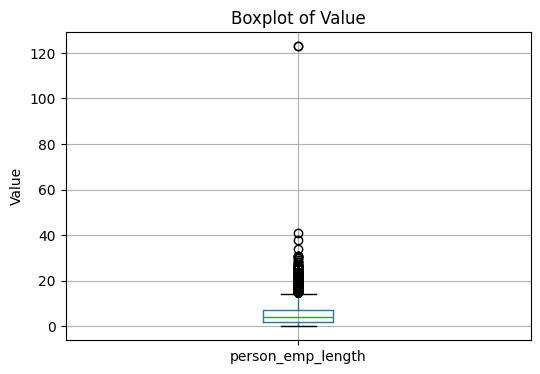

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
data.boxplot(column=['person_emp_length'])
plt.title('Boxplot of Value')
plt.ylabel('Value')
plt.show()

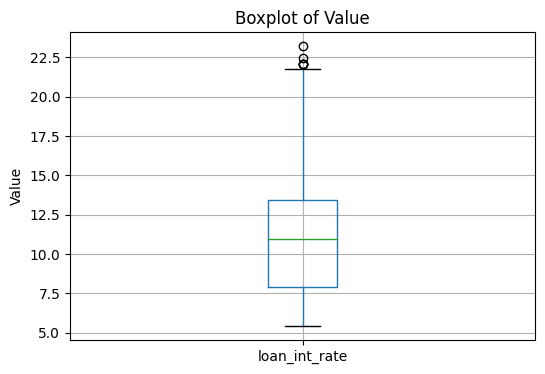

In [8]:
plt.figure(figsize=(6,4))
data.boxplot(column=['loan_int_rate'])
plt.title('Boxplot of Value')
plt.ylabel('Value')
plt.show()

# Data preprocessing: Fill missing values

In [9]:
data['person_emp_length'] = data['person_emp_length'].fillna(data['person_emp_length'].median())

In [10]:
mean_loan_int_rate_by_grade = data.groupby('loan_grade')['loan_int_rate'].mean()

In [11]:
def fill_loan_int_rate(row):
    if pd.isnull(row['loan_int_rate']):
        return mean_loan_int_rate_by_grade[row['loan_grade']]
    else:
        return row['loan_int_rate']

In [12]:
data['loan_int_rate'] = data.apply(fill_loan_int_rate, axis=1)

In [14]:
data.isnull().sum()

person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_status                   0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
dtype: int64

In [15]:
data.describe()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,32581.000000,3.258100e+04,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000,32581.000000
mean,27.734600,6.607485e+04,4.767994,9589.371106,11.009816,0.218164,0.170203,5.804211
std,6.348078,6.198312e+04,4.087372,6322.086646,3.219338,0.413006,0.106782,4.055001
min,20.000000,4.000000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,23.000000,3.850000e+04,2.000000,5000.000000,7.880000,0.000000,0.090000,3.000000
50%,26.000000,5.500000e+04,4.000000,8000.000000,10.995555,0.000000,0.150000,4.000000
75%,30.000000,7.920000e+04,7.000000,12200.000000,13.463542,0.000000,0.230000,8.000000
max,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


# Data preprocessing: One-hot encoding

In [16]:
data = pd.get_dummies(data, columns=['person_home_ownership', 'loan_intent', 'loan_grade', 'cb_person_default_on_file'])

# Splitting data into features and target variable

In [17]:
labels =data.loan_status
data.drop(["loan_status"],axis=1,inplace=True)

# Train-test split

In [18]:
X_train,X_test,Y_train,Y_test = train_test_split(data,labels,stratify=labels,random_state=42,test_size=0.2)

# Standardize features

In [19]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression

In [20]:
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, Y_train)
logistic_predValues = log_reg.predict(X_test_scaled)

## Evaluation metrics

In [21]:
log_reg_accuracy = accuracy_score(Y_test, logistic_predValues)
log_reg_fscore = f1_score(Y_test, logistic_predValues)
log_reg_recall = recall_score(Y_test, logistic_predValues)
log_reg_precision = precision_score(Y_test, logistic_predValues)
log_reg_confusion = confusion_matrix(Y_test, logistic_predValues)

logistic_pred_probs = log_reg.predict_proba(X_test_scaled)[:, 1]
fpr_LR, tpr_LR, thresholds_LR = roc_curve(Y_test, logistic_pred_probs)
auc_score_LR = auc(fpr_LR, tpr_LR)

### Visualize confusion matrix

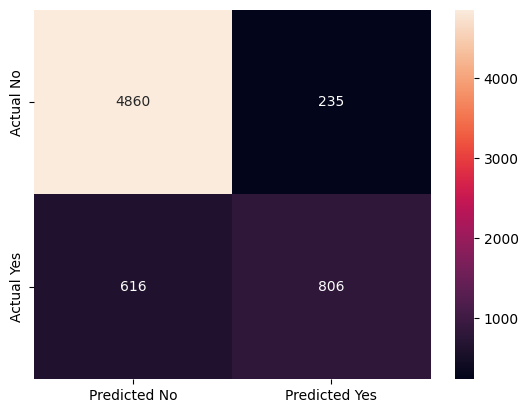

In [22]:
sns.heatmap(log_reg_confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

# Naive Bayes

In [23]:
naive_clf = GaussianNB()
naive_clf.fit(X_train, Y_train)
naive_predValues = naive_clf.predict(X_test)

## Evaluation metrics

In [24]:
NB_accuracy = accuracy_score(Y_test,naive_predValues)
NB_fscore = f1_score(Y_test,naive_predValues)
NB_recall = recall_score(Y_test,naive_predValues)
NB_precision = precision_score(Y_test,naive_predValues)
NB_confusion = confusion_matrix(Y_test,naive_predValues)

fpr_NB, tpr_NB, thresholds_NB = roc_curve(Y_test, naive_clf.predict_proba(X_test)[:, 1])
auc_score_NB = auc(fpr_NB, tpr_NB)

### Visualize confusion matrix

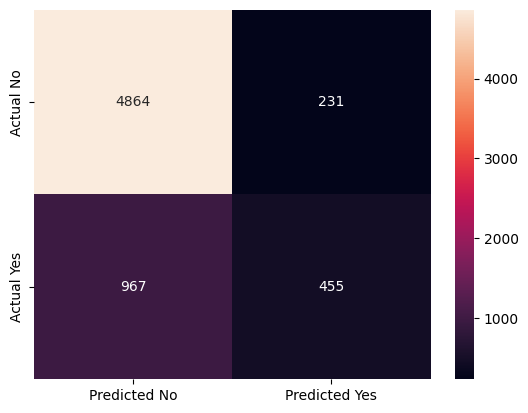

In [25]:
sns.heatmap(NB_confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

# Decision Tree

In [26]:
tree_clf = DecisionTreeClassifier()
start = time.time()
tree_clf.fit(X_train, Y_train)
tree_trainTime = time.time() - start
tree_predValues = tree_clf.predict(X_test)

## Evaluation metrics

In [27]:
DT_accuracy = accuracy_score(Y_test,tree_predValues)
DT_fscore = f1_score(Y_test,tree_predValues)
DT_recall = recall_score(Y_test,tree_predValues)
DT_precision = precision_score(Y_test,tree_predValues)
DT_confusion = confusion_matrix(Y_test,tree_predValues)

tree_pred_probs = tree_clf.predict_proba(X_test)[:, 1]
fpr_DT, tpr_DT, thresholds_DT = roc_curve(Y_test, tree_pred_probs)
auc_score_DT = auc(fpr_DT, tpr_DT)

### Visualize confusion matrix

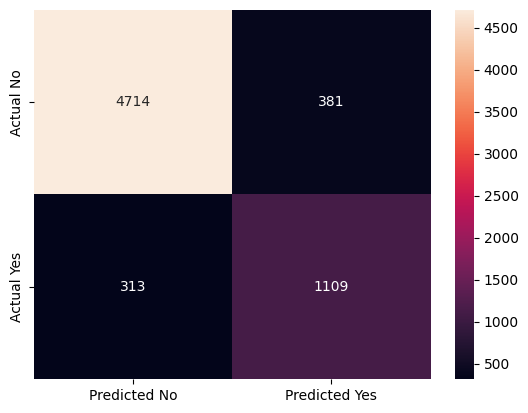

In [28]:
sns.heatmap(DT_confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

# Support Vector Machine

In [29]:
svc = SVC()
svc.fit(X_train_scaled,Y_train)
svm_predValues = svc.predict(X_test_scaled)

## Evaluation metrics

In [30]:
svm_accuracy = accuracy_score(Y_test,svm_predValues)
svm_fscore = f1_score(Y_test,svm_predValues)
svm_recall = recall_score(Y_test,svm_predValues)
svm_precision = precision_score(Y_test,svm_predValues)
svm_confusion = confusion_matrix(Y_test,svm_predValues)

svm_decision_values = svc.decision_function(X_test_scaled)
fpr_SVM, tpr_SVM, thresholds = roc_curve(Y_test, svm_decision_values)
auc_score_SVM = auc(fpr_SVM, tpr_SVM)

### Visualize confusion matrix

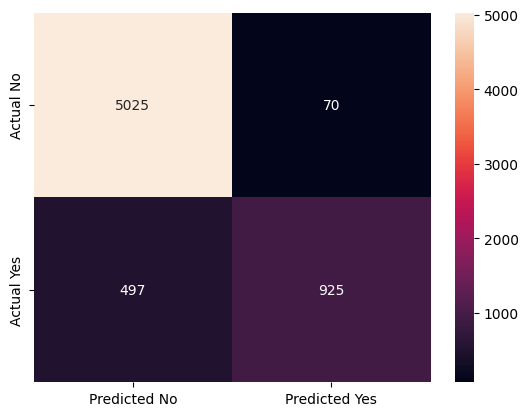

In [31]:
sns.heatmap(svm_confusion,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

# XGBoost

In [32]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_test, label=Y_test)

params = {
    'objective': 'binary:logistic', 
    'eval_metric': 'error',
    'tree_method': 'hist', 
    "device": "cuda"
}

num_rounds = 100
bst = xgb.train(params, dtrain, num_rounds)

y_pred = bst.predict(dtest)
y_pred_binary = [round(value) for value in y_pred]

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [00:25:12] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


## Evaluation metrics

In [33]:
XG_accuracy = accuracy_score(Y_test, y_pred_binary)
XG_precision = precision_score(Y_test, y_pred_binary)
XG_recall = recall_score(Y_test, y_pred_binary)
XG_f1 = f1_score(Y_test, y_pred_binary)
XG_conf_matrix = confusion_matrix(Y_test, y_pred_binary)

fpr_xg, tpr_xg, thresholds = roc_curve(Y_test, y_pred)
auc_score_xg = auc(fpr_xg, tpr_xg)

### Visualize confusion matrix

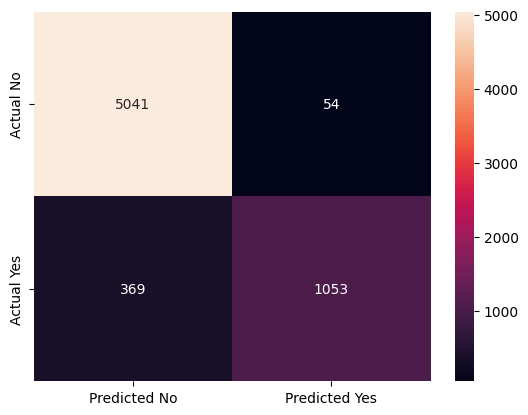

In [34]:
sns.heatmap(XG_conf_matrix,annot = True,fmt="d",xticklabels = ["Predicted No","Predicted Yes"],yticklabels = ["Actual No","Actual Yes"])
plt.show()

# Model comparison

In [35]:
data_comparison = [[log_reg_accuracy,log_reg_fscore,log_reg_recall,log_reg_precision],
                  [NB_accuracy,NB_fscore,NB_recall,NB_precision],
                  [svm_accuracy,svm_fscore,svm_recall,svm_precision],
                  [XG_accuracy,XG_f1,XG_recall,XG_precision]]

comparison = pd.DataFrame(data_comparison,index= ['Logistic regression','Naive bayes','SVM','XGboost'],
                                 columns=['Accuracy','f1_score','Recall','Precision'])

In [36]:
print("Model Comparison:")
comparison

Model Comparison:


,Accuracy,f1_score,Recall,Precision
Logistic regression,0.869418,0.654486,0.566807,0.774256
Naive bayes,0.816173,0.431689,0.319972,0.663265
SVM,0.912997,0.765412,0.650492,0.929648
XGboost,0.935093,0.832740,0.740506,0.951220


# Plot ROC curve

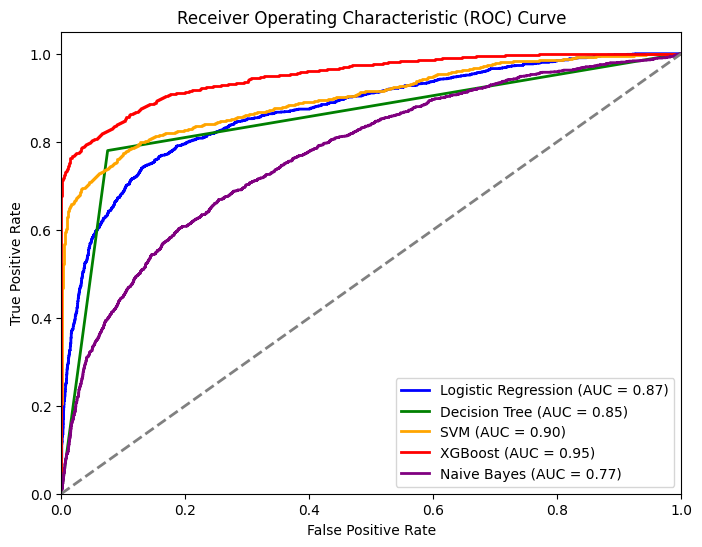

In [37]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_LR, tpr_LR, color='blue', lw=2, label=f'Logistic Regression (AUC = {auc_score_LR:.2f})')
plt.plot(fpr_DT, tpr_DT, color='green', lw=2, label=f'Decision Tree (AUC = {auc_score_DT:.2f})')
plt.plot(fpr_SVM, tpr_SVM, color='orange', lw=2, label=f'SVM (AUC = {auc_score_SVM:.2f})')
plt.plot(fpr_xg, tpr_xg, color='red', lw=2, label=f'XGBoost (AUC = {auc_score_xg:.2f})')
plt.plot(fpr_NB, tpr_NB, color='purple', lw=2, label=f'Naive Bayes (AUC = {auc_score_NB:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()